In [1]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import h5py
import os
import sys
from fooof import FOOOF

MODEL_PATH = os.path.join('..', 'M1Focus')
sys.path.append(MODEL_PATH)
from build_input import get_stim_cycle, t_start, on_time, off_time

TRIAL_NAME = "baseline_test_1"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

isbaseline = True

In [2]:
ecp_file = "ecp.h5"
with h5py.File(os.path.join(TRIAL_PATH, ecp_file), 'r') as f:
    lfp = f['ecp']['data'][:, 0]
    lfp -= np.mean(lfp)
    t = np.arange(*f['ecp']['time'])
    fs = 1000 / f['ecp']['time'][2] # sampling rate Hz

In [3]:
if isbaseline:
    on_time, off_time = on_time + off_time, 0.0
else:
#     # if any correction needed
#     t_start = 1.0  # sec. Time to start burst input
#     on_time = 0.5  # sec. Burst input duration
#     off_time = 0.5  # sec. Silence duration
    pass

t_stop = t.size / fs # Simulation time
t_cycle, n_cycle = get_stim_cycle(on_time=on_time, off_time=off_time, t_start=t_start, t_stop=t_stop)

In [4]:
tseg = .25 # time segment length for PSD (second)
nfft = int(tseg * fs) # steps per segment
i_start = int(t_start * fs)
i_on = int(on_time * fs)
i_cycle = int(t_cycle * fs)
nseg_cycle = int(np.ceil(i_on / nfft))
lfp_on = np.zeros(n_cycle * nseg_cycle * nfft)

for i in range(n_cycle):
    m = i_start + i * i_cycle
    for j in range(nseg_cycle):
        x = lfp[m + j * nfft:m + min((j + 1) * nfft, i_on)]
        n = (i * nseg_cycle + j) * nfft
        lfp_on[n:n + x.size] = x
f, pxx = ss.periodogram(lfp_on, fs=fs, nfft=nfft)

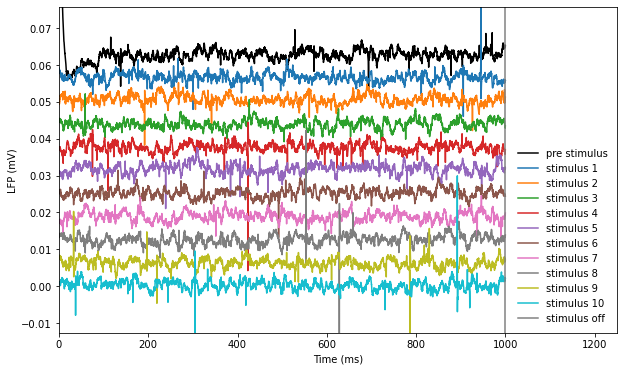

In [5]:
dv_n_sigma = 5
dv = dv_n_sigma * np.std(lfp[i_start:])

plt.figure(figsize=(10, 6))
plt.plot(t[:i_start], lfp[:i_start] + n_cycle * dv, 'k', label='pre stimulus')
for i in range(n_cycle):
    m = i_start + i * i_cycle
    x = lfp[m:m + i_cycle] + (n_cycle - i - 1) * dv
    plt.plot(t[:i_cycle], x, label=f'stimulus {i + 1:d}')
plt.axvline(on_time * 1000, color='gray', label='stimulus off')
plt.xlim([0, max(1.25 * t_cycle, t_start) * 1000])
plt.ylim(np.array((-2, n_cycle + 2)) * dv)
plt.xlabel('Time (ms)')
plt.ylabel('LFP (mV)')
plt.legend(loc='lower right', frameon=False)
plt.show()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 8 - 500 Hz                        
                                 Frequency Resolution is 4.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -3.5612, 9299.8653, 2.7837                                    
                                                                                                  
                                       10 peaks were found:                                       
          

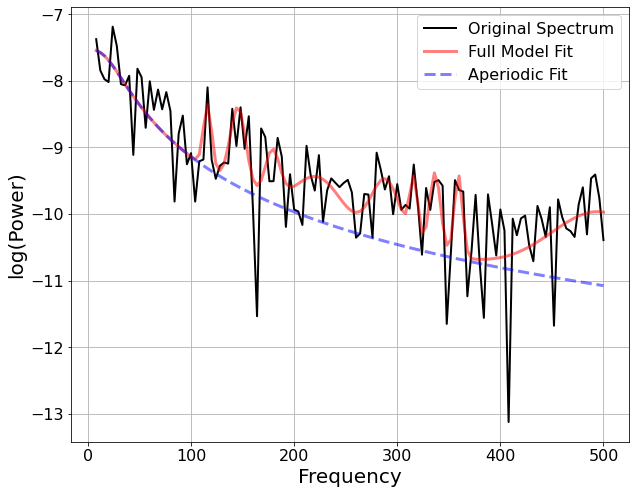

In [6]:
aperiodic_mode = 'knee' # 'knee' or 'fixed'
dB_threshold = 3. # decibel
freq_range = [f[2], 500.]
peak_width_limits = [f[2], 100.]
max_n_peaks = 10

# Initialize a FOOOF object
fm = FOOOF(peak_width_limits=peak_width_limits, min_peak_height=dB_threshold / 10,
           peak_threshold=0.0, max_n_peaks=max_n_peaks, aperiodic_mode='knee')

# Alternatively, just fit the model with FOOOF.fit() (without printing anything)
fm.fit(f, pxx, freq_range)
results = fm.get_results()

# After fitting, plotting and parameter fitting can be called independently:
fm.print_results()
fm.plot(plt_log=False)

In [7]:
if aperiodic_mode=='knee':
    ap_params = results.aperiodic_params
    if ap_params[1] <= 0:
        print('Negative value of knee parameter occurred. Suggestion: Fit without knee parameter.')
    knee_freq = np.abs(ap_params[1]) ** (1 / ap_params[2])
    print(f'Knee location: {knee_freq:.2f} Hz')

Knee location: 26.64 Hz


In [8]:
SAVE_PATH = os.path.join(TRIAL_PATH, 'FOOOF_results')
fm.save(SAVE_PATH, save_results=True, save_settings=True, save_data=True)

# Save out a report of the current model fit & results
REPORT_PATH = os.path.join(TRIAL_PATH, 'FOOOF_report')
fm.save_report(REPORT_PATH, plt_log=False)